In [4]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
from pandas.core.methods.to_dict import to_dict
%matplotlib inline

In [5]:
jamb_exam_df = pd.read_csv('../../data/06-week/jamb_exam_results.csv')

In [6]:
jamb_exam_df.columns = jamb_exam_df.columns.str.lower().str.replace(' ', '_')

## Data Preparation 

In [8]:
jamb_exam_df = jamb_exam_df.drop('student_id',axis = 1 )

In [9]:
jamb_exam_df.isnull().sum()

jamb_score                        0
study_hours_per_week              0
attendance_rate                   0
teacher_quality                   0
distance_to_school                0
school_type                       0
school_location                   0
extra_tutorials                   0
access_to_learning_materials      0
parent_involvement                0
it_knowledge                      0
age                               0
gender                            0
socioeconomic_status              0
parent_education_level          891
assignments_completed             0
dtype: int64

In [10]:
jamb_exam_df.fillna(0,inplace=True)

In [11]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(jamb_exam_df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [12]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.jamb_score
y_val = df_val.jamb_score
y_test = df_test.jamb_score

del df_train['jamb_score']
del df_val['jamb_score']
del df_test['jamb_score']

In [13]:
### DT Regressor 

from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import mean_squared_error

In [14]:
train_dicts = df_train.fillna(0).to_dict(orient='records')


In [15]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

In [17]:
val_dicts = df_val.fillna(0).to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [24]:
## Q1 Restricting the depth to only 1 level 
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)


y_pred = dt.predict(X_train)
rms = mean_squared_error(y_train, y_pred,squared=False)
print('train:', rms)

y_pred = dt.predict(X_val)
rms = mean_squared_error(y_val, y_pred,squared=False)
print('val:', rms)

train: 44.03387763193034
val: 45.80335905740839


In [25]:
from sklearn.tree import export_text

In [26]:
print(export_text(dt,feature_names=dv.get_feature_names_out()))

|--- study_hours_per_week <= 18.50
|   |--- value: [155.24]
|--- study_hours_per_week >  18.50
|   |--- value: [188.59]



In [27]:
### Randomforest regressor 
from sklearn.ensemble import RandomForestRegressor

In [29]:
rf = RandomForestRegressor(n_estimators=10,random_state=1,n_jobs=-1)
rf.fit(X_train,y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [30]:
y_pred = rf.predict(X_train)
rms = mean_squared_error(y_train, y_pred,squared=False)
print('train:', rms)

y_pred = rf.predict(X_val)
rms = mean_squared_error(y_val, y_pred,squared=False)
print('val:', rms)

train: 17.78903210782794
val: 42.13724207871227


In [69]:
scores = []

for n in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_val)
    rms = mean_squared_error(y_val, y_pred,squared=False)
    
    scores.append((n, rms))


In [70]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rms'])

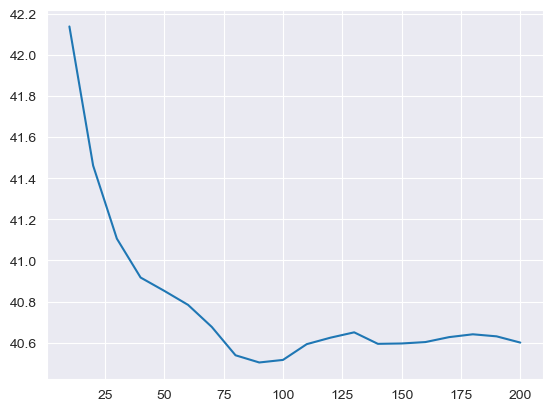

In [71]:
plt.plot(df_scores.n_estimators, df_scores.rms)

In [74]:
df_scores[df_scores.rms == df_scores.rms.min()]

,n_estimators,rms
8,90,40.504346


In [73]:
df_scores.rms.min()

40.50434592594835

In [40]:
### Question 4 

scores = []

for d in [10, 15, 20, 25]:
    rms = []
    for n in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=n,
                                    max_depth=d,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        rms .append(mean_squared_error(y_val, y_pred,squared=False))

    scores.append((d, np.mean(rms)))

In [42]:
scores

[(10, 40.39249798892396),
 (15, 40.73528172486332),
 (20, 40.739734321829275),
 (25, 40.78786565962805)]

In [43]:
## Question 5

rf = RandomForestRegressor(n_estimators=10,max_depth=20,random_state=1,n_jobs=-1)
rf.fit(X_train, y_train)


RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [44]:
y_pred = rf.predict(X_val)
rms .append(mean_squared_error(y_val, y_pred,squared=False))


In [49]:
feature_importance_df  = pd.DataFrame(dict(column_name = dv.get_feature_names_out(),feature_importance = rf.feature_importances_))

<Axes: xlabel='feature_importance', ylabel='column_name'>

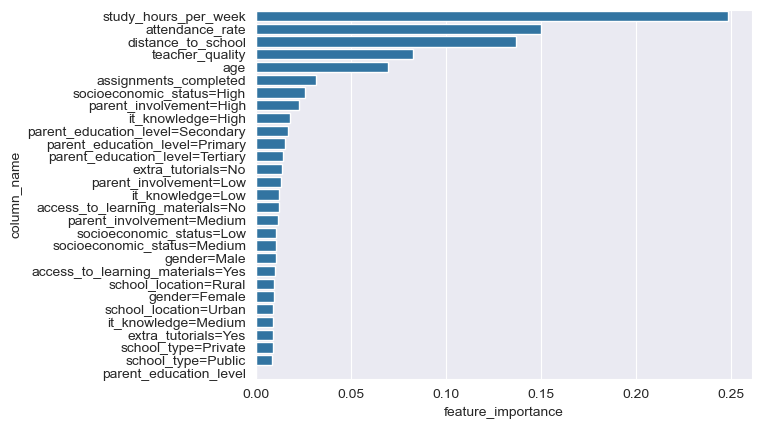

In [51]:
sns.barplot(feature_importance_df\
                .sort_values(by='feature_importance',ascending=False), x = 'feature_importance', y = 'column_name')

In [ ]:
### XGBoost 


In [52]:
import xgboost as xgb

In [53]:

features = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [55]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [64]:
%%capture output

xgb_params = {
        'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,

        'objective': 'reg:squarederror',
         'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5, ## Print every 5 steps 
                  evals=watchlist )

In [57]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_rms', 'val_rms']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [61]:
df_score = parse_xgb_output(output)

In [63]:
## ETA - 0.3 
y_pred = model.predict(dval)

mean_squared_error(y_val, y_pred,squared=False)


44.432098039002526

In [65]:
## ETA - 0.1 

y_pred = model.predict(dval)

mean_squared_error(y_val, y_pred,squared=False)

41.043354592351655